# NNs for Classsification with PyTorch

Here is a simple introduction to classification with neural networks, based on this [tutorial](https://www.datacamp.com/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch). Recall the basic architecture of a Neural Network, made of:

- input layer
- hidden layers
- output layer.

![](./three_layer_neural_network_e50fa950bc.png)

Recall also that we need to define the following:

- weight initialization (unless we use the default)
- activation function
- loss function.

Finally, the optimizer can have hyperparameters that need to be tuned, in general.



## A few technical points

### Initialization

For certain, more difficult ML problems, the scheme used to initilize the network weights can be important.
Weight initialization can alleviate the well-known problems of vanishing or exploding gradients in deep networks.

- **Random** can exhibit scaling problems
- **Xavier/Glorot** is based on variance balancing, and avoids vanishing gradient problems - it is commonly used with *tanh* or *sigmoid* activations
- **He** uses a different scaling, but similar to Glorot - it is recommended for *ReLU* activations and deep nets, where it is better at preventing vanishing gradients

### Activation Functions

These have been discussed in the Lectures.

- sigmoid or logistic function
- tanh function
- ReLu function that can avoid vanishing gradients


## Building an NN

### Data loading and preparation

We use `make_circles` from `scikit-learn` to define a binary classification problem. We start with the usual splitiing into training and testing (sub)sets.

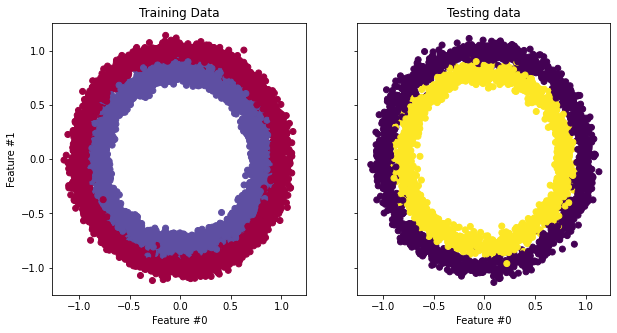

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

# Create a dataset with 10,000 samples.
X, y = make_circles(n_samples = 10000,
                    noise= 0.05,
                    random_state=26)
# Split into train:test with ration 1:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=26)
# Visualize the data.
fig, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)
train_ax.set_title("Training Data")
train_ax.set_xlabel("Feature #0")
train_ax.set_ylabel("Feature #1")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
test_ax.set_title("Testing data")
plt.show()

### Convert arrays to PyTorch

We must first convert the training and testing data from `numpy` to `pytorch` **tensors**. We also prepare the training batches using the  [Dataloader](https://pytorch.org/docs/stable/data.html) module that facilitates batch training.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Convert data to torch tensors
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

batch_size = 64
    
# Instantiate training and test data
train_data = Data(X_train, y_train)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

test_data = Data(X_test, y_test)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

# Check it's working
for batch, (X, y) in enumerate(train_dataloader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break


Batch: 1
X shape: torch.Size([64, 2])
y shape: torch.Size([64])


### NN implementation and model training

We implement a simple NN with
- two layers
- ReLU activation function, `torch.nn.functional.relu`. 

For this, we construct a class, `NeuralNetwork` that inherits from the base class `nn.Module`.



In [3]:
import torch
from torch import nn
from torch import optim

input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
       
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer_1(x))
        x = torch.nn.functional.sigmoid(self.layer_2(x))

        return x
       
model = NeuralNetwork(input_dim, hidden_dim, output_dim)
print(model)

NeuralNetwork(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=1, bias=True)
)


### Training

We require a **loss function** before we can train, and a definition of the optimizer we want to use. In our case, we choose

- binary cross-entropy (BCE)
- stochastic gradient descent (SGD)

Then we can train the model by 

- looping over the epochs, 
- calculating the loss, 
- calculating its gradient wrt the weights, and finally
- updating the weights.


In [4]:
learning_rate = 0.1
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# ready to train

num_epochs = 100
loss_values = []


for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()      
        # forward + backward + optimize
        pred = model(X)
        loss = loss_fn(pred, y.unsqueeze(-1))
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()

print("Training Complete")

Training Complete


### Visualization

Since we tracked the loss values, we can now plot them as a function of the iteration/epoch.

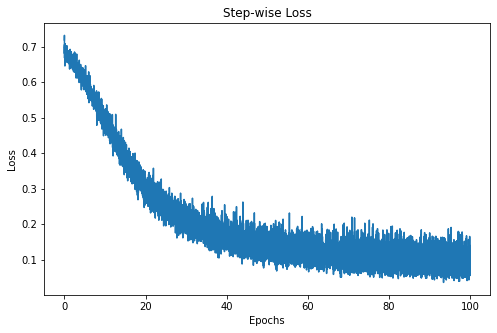

In [5]:
step = np.linspace(0, 100, 10500)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Step-wise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

We observe a rapid decrease for the first 20 iterations, then a flattening out. This is the "noise-ball" phenomenon of SGD and can be improved by changing the learning rate...

### Predictions and Model Evaluation

The trained model can now be used to make predictions.

In [7]:
import itertools

y_pred = []
y_test = []
total = 0
correct = 0

with torch.no_grad():  # grad not needed here (only for training)
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        #y_pred.append(predicted)
        #y_test.append(y)
        y_pred = np.append(y_pred, predicted)
        y_test = np.append(y_test, y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

print(f'Accuracy of the network on the 3300 test instances: {100 * correct // total}%')


Accuracy of the network on the 3300 test instances: 98%


### Reporting

Finally, we can use `sklearn` to generate a complete classification report with a confusion table.

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1635
         1.0       0.98      0.99      0.98      1665

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



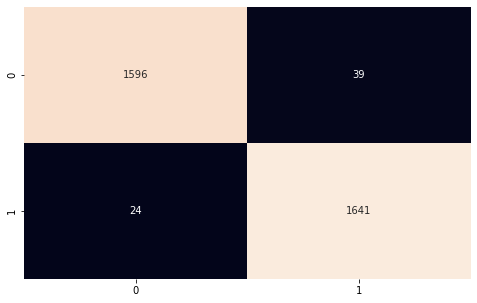

In [8]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns

#y_pred = list(itertools.chain(*y_pred))
#y_test = list(itertools.chain(*y_test))
print(classification_report(y_test, y_pred))

"""
              precision    recall  f1-score   support

        0.0       0.98      0.97      0.98      1635
        1.0       0.98      0.98      0.98      1665

    accuracy                           0.98      3300
  macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300

"""

cf_matrix = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(8, 5))
sns.heatmap(cf_matrix, annot=True, cbar=False, fmt="g")
plt.show()